<a href="https://colab.research.google.com/github/dwi11harsh/micrograd/blob/main/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Building Micrograd</h1>
This Notebook explains the <a href="https://youtu.be/VMj-3S1tku0?si=9F4b9_SziPxp53SM">The spelled-out intro to neural networks and backpropagation: building micrograd</a> by <a href="https://karpathy.ai/">Andrej Karpathy</a>.<br>


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [41]:
# a simple function that takes in a single scalar `x` and returns a single scalar `y`
def f(x):
  return 3*x**2 - 4*x + 5

In [42]:
f(3)

20

In [43]:
# now creating some x values
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [44]:
# and now some y values using the function described above
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

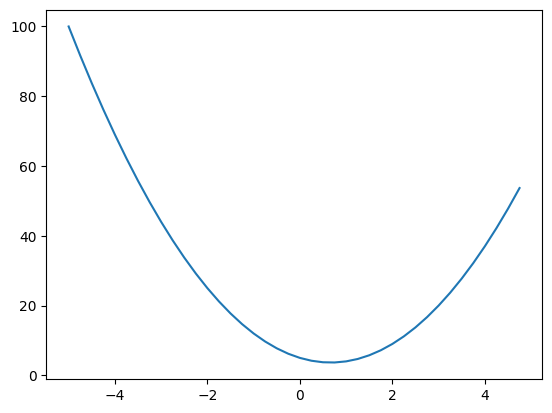

In [45]:
# plotting these xs and ys
plt.plot(xs, ys)

In [46]:
# Now, (from calculus class) a derivative of a function at any point is the measure of how sensitive the function is at that point
# if we slightly bump up (or down) the value of the argument which we are passing. This change is offcourse infinitely small (close to 0).
# lets take a very small `h`
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

In [47]:
# now if we calculate by hand then derivative of our function would be 6x-4 and equating it with 0 we get x=2/3
# so at x = 2/3 the derivative is not very responsive to infinitely small changes in h

In [48]:
h=0.000001
x=2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [49]:
# now writing a small equation to understand the effect of nudging any of its variables
a = 2.0
b = -3.0
c = 10.0

# equation
d = a*b + c
d

4.0

In [50]:
# nudging each of the variables to see how much each of them affect this value (4.0)

h = 0.0001

# nudging `a`
a1 = a + h

d1 = a1*b + c

# now wile finding the differential w.r.t a we expect a negative slope coz when we differentiate the equation w.r.t `a` we get b and it is negative
# so we should be left with a value close to b
(d1-d)/h

-3.000000000010772

In [51]:
# nudging `b`
b1 = b + h

d2 = a*b1 + c

# now wile finding the differential w.r.t `b` we expect a value close to `a`
(d2-d)/h

2.0000000000042206

In [52]:
# nudging `c`
c1 = c + h

d3 = a*b + c1

# now wile finding the differential w.r.t `c` we expect a slope of one as there would be just 1 left while partially differentiating original equation w.r.t. c
(d3-d)/h

0.9999999999976694

In [53]:
# so now we have some sense of what this derivative function actually represents

In [54]:
# now lets get cookin
# first we need to build a data structure which can store our neural nets

class Value:
  def __init__(self, data):   # this will be used to initialize any variable
    self.data = data

  def __repr__(self):         # repr allows us to print a better looking expression or else we get something we wont be expecting
    return f"Value(data={self.data})"

  def __add__(self, other):
    return Value(self.data + other.data)    # internally it calculates a.__add__(b)

  def __mul__(self, other):
    return Value(self.data * other.data)

In [55]:
# now that we have our data structure, lets try to recreate the above expression with this data structure

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

# and now we should be able to recreate the above expression

a*b + c # this calls the following expression internally
# (a.__mul__(b)).__add__(c)

Value(data=4.0)

In [56]:
# since we already have the basic data structure, what we need now is to have a method which would tell us the values which produced the newer values

# for this purpose we add an empty tuple during initialization to this data structure which then keeps record of the initial values used to create the newer values
class Value:
  def __init__(self, data, _children=()):
    self.data = data
    self._prev = set(_children) # now inside the class we are instead maintaining a set (just for efficiency purpose, dont fuss about it)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other))
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other))
    return out


a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d

Value(data=4.0)

In [57]:
# but the amazing thing that we can do now is know which values contributed to output d
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [58]:
# and the last thing we need is to also maintain what expressions contributed to this end value
class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out


a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b
e._label='e'
d = e + c
d._label='d'
f = Value(-2.0, _label='f')
L = d*f
L._label='L'
L

Value(data=-8.0)

In [59]:
# and now we can also know the expression which was performed to get the output value
d._op, d._prev, d

('+', {Value(data=-6.0), Value(data=10.0)}, Value(data=4.0))

In [60]:
# so this tells us that a + op was performed on Value -6.0 and Value 10.0 to get the value 4

In [61]:
# we know that in neurals, these expressions could get really big, so, we need a way to easily visualize our data structure and for that we are going to use graphviz
from graphviz import Digraph

# getting all the nodes and edges by tracing the data structure
def trace(root):
  # building a set of all the nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)

  return nodes, edges

# generating the graph
def draw_graph(root):
  graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes,edges = trace(root)

  for node in nodes:
    uid = str(id(node))
    # for any value in graph, create a rectangular node for it
    graph.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (node._label, node.data, node.grad ), shape='record')

    if node._op:
      # if this value is a result of some operation, create an operation node for it
      graph.node(name = uid + node._op, label = node._op)
      # and connect this node to it
      graph.edge(uid + node._op, uid)

  for n1, n2 in edges:
    # connect n1 to the operation node of n2
    graph.edge(str(id(n1)), str(id(n2)) + n2._op)

  return graph

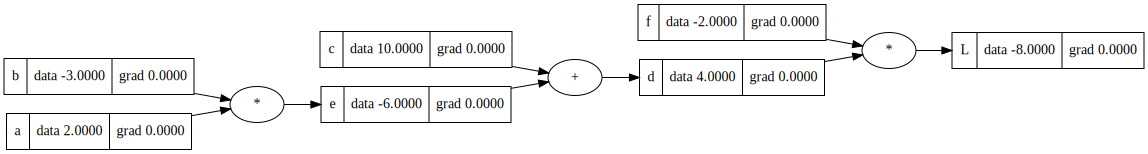

In [62]:
draw_graph(L)

# Manual Backpropagation Equations
1. $ \frac{dL}{dL} = 1   $

  The derivative of a variable with respect to itself is always 1.

2. $ \frac{dL}{da} = \frac{d((a \cdot b + c) \cdot f)}{da} = b \cdot f = (-3.0) \cdot (-2.0) = 6.0 $


3. $ \frac{dL}{db} = \frac{d((a \cdot b + c) \cdot f)}{db} = a \cdot f = 2.0 \cdot (-2.0) = -4.0 $

4. $ \frac{dL}{dc} = \frac{d((a \cdot b + c) \cdot f)}{dc} = f = -2.0 $

5. $ \frac{dL}{dd} = \frac{d(d \cdot f)}{dd} = f = -2.0 $

6. $ \frac{dL}{de} = \frac{d((e + c) \cdot f)}{de} = f = -2.0 $

7. $ \frac{dL}{df} = \frac{d(d \cdot f)}{df} = d = 4.0 $

In [63]:
# manual backpropagation

def man_back():
  h = 0.001

  # original value of L
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L1=L.data

  # effect of increasing increasing `L` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L2=L.data + h

  print("derivative of `L` w.r.t. `L`:", (L2-L1)/h) # o/p: 1.000000000000334


  # effect of increasing increasing `a` by `h` on `L`
  a = Value(2.0 + h, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L3=L.data

  print("derivative of `L` w.r.t. `a`:", (L3-L1)/h) # o/p: 6.000000000000227


  # effect of increasing increasing `b` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0 + h, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L4=L.data

  print("derivative of `L` w.r.t. `b`:", (L4-L1)/h) # o/p: -3.9999999999995595


  # effect of increasing increasing `c` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0 + h, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L5=L.data

  print("derivative of `L` w.r.t. `c`:", (L5-L1)/h) # o/p: -1.9999999999988916


  # effect of increasing increasing `d` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d.data += h
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L6=L.data

  print("derivative of `L` w.r.t. `d`:", (L6-L1)/h) # o/p: 2.0009999999990313


  # effect of increasing increasing `e` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  e.data += h
  d = e + c
  d._label='d'
  f = Value(-2.0, _label='f')
  L = d*f
  L._label='L'
  L6=L.data

  print("derivative of `L` w.r.t. `e`:", (L6-L1)/h) # o/p: 2.0009999999990313


  # effect of increasing increasing `f` by `h` on `L`
  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a*b
  e._label='e'
  d = e + c
  d._label='d'
  f = Value(-2.0 + h, _label='f')
  L = d*f
  L._label='L'
  L6=L.data

  print("derivative of `L` w.r.t. `f`:", (L6-L1)/h) # o/p: 3.9999999999995595


man_back()

derivative of `L` w.r.t. `L`: 1.000000000000334
derivative of `L` w.r.t. `a`: 6.000000000000227
derivative of `L` w.r.t. `b`: -3.9999999999995595
derivative of `L` w.r.t. `c`: -1.9999999999988916
derivative of `L` w.r.t. `d`: -2.000000000000668
derivative of `L` w.r.t. `e`: -2.000000000000668
derivative of `L` w.r.t. `f`: 3.9999999999995595


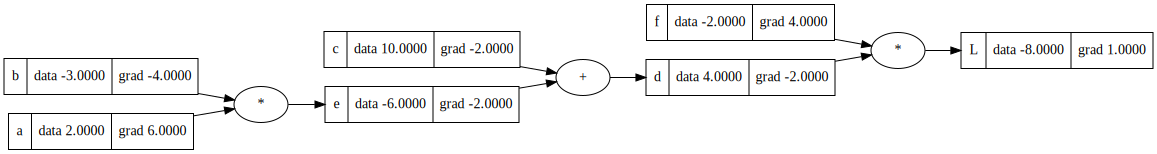

In [64]:
# lets the fill these values to the gradients
L.grad = 1.0
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0
e.grad = -2.0
f.grad = 4.0
draw_graph(L)

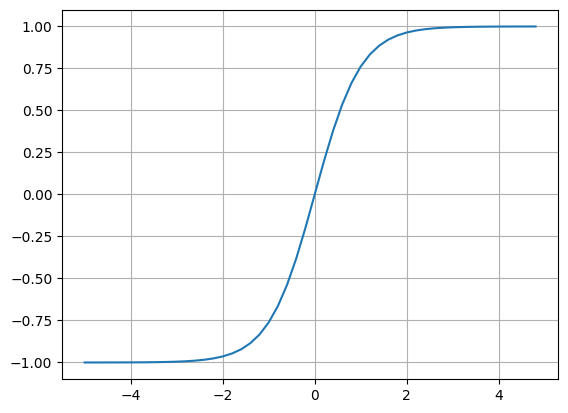

In [65]:
# an example of what a tanh curve looks like
plt.plot(np.arange(-5.0, 5.0, 0.2), np.tanh(np.arange(-5.0, 5.0, 0.2)))
plt.grid()

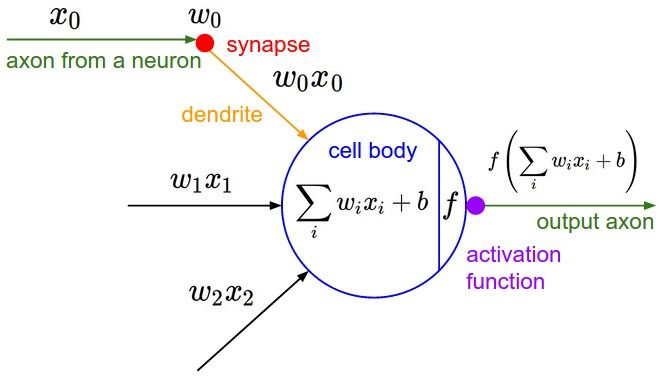

In [66]:
class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self,), _op='tanh')
    return out

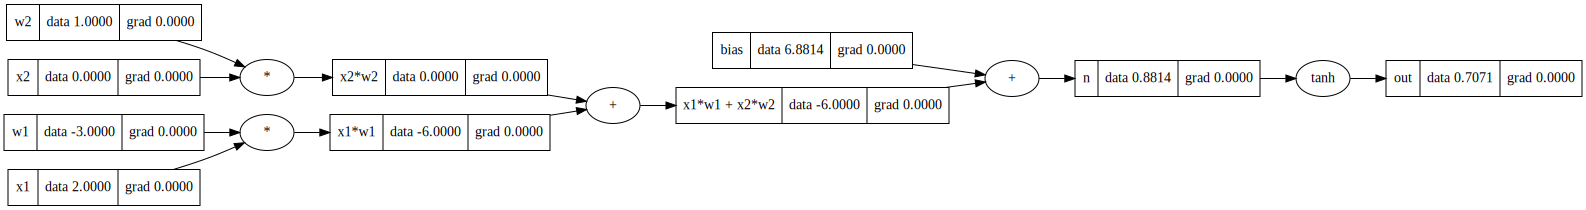

In [67]:
# Now, our goal is to implement this artificial neuron and use the tanh activation function

# inputs
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias of the neuron
bias = Value(6.8813735870195432, _label='bias')

x1w1 = x1*w1
x2w2 = x2*w2

x1w1._label = 'x1*w1'
x2w2._label = 'x2*w2'

# x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias
n._label = 'n'

out = n.tanh()
out._label = 'out'

draw_graph(out)

In [68]:
# now we will again be manually backpropagating through this network and calculating the derivative of `out` w.r.t. x1,w1,x2,w2
# but what we actually want is to calculate the gradient of w1 & w2 (the weights) coz that is what we will be adjusting in the actual neural net

$  \frac{d}{dx}\tanh x = 1 - \tanh^2 x = \operatorname{sech}^2 x = \frac{1}{\cosh^2 x} $


So, we will be using the relation

$ \frac{d}{dx}\tanh x = 1 - \tanh^2 x $

Since, $ n = w1x1 + w2x2 + bias $

so the gradient will flow equally to bias and $ w1x1w2x2 $ node

and for same reason $ x1w1 $ and $ x2w2 $ will get the same weight

from chain rule, we can also calculate the gradient of $ x1 $, $ w1 $, $ x2 $ & $ w2 $, i.e. ,

$ \frac{d}{dx2}(out) =  \frac{d(x2w2)}{dx2} \cdot \frac{d}{d(x2w2)}(out) = w2 \cdot \frac{d}{d(x2w2)}(out) $

& with similar reasoning we can find out the gradients of $ w1, x1, w2 $

In [69]:
1 - out.data**2

0.4999999999999999

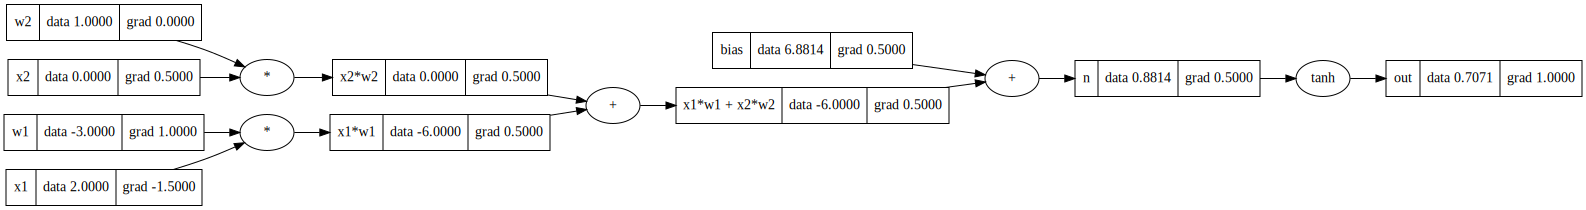

In [70]:
out.grad = 1
n.grad = 0.5

x1w1x2w2.grad = 0.5
bias.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_graph(out)

In [71]:
# now lets add another method to our Value class called _backward which does backpropagation for us and assigns the gradient values for us

class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad    # as the addition operation just results in the transfer of same gradient from its outputs to its inputs
      other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad   # as explained above in chain rule
      other.grad = self.data * out.grad

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self,), _op='tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad   # using the chain rule and exponential derivative of tanh

    out._backward = _backward

    return out

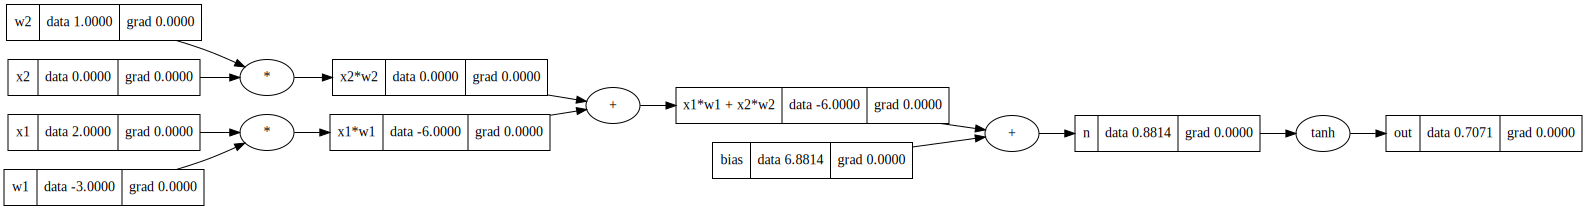

In [72]:
# now lets use the previous expression and values to re-evaluate the same derivatives so that we know its correct

# inputs
x1 = Value(2.0, _label='x1')#
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias of the neuron
bias = Value(6.8813735870195432, _label='bias')

x1w1 = x1*w1
x2w2 = x2*w2

x1w1._label = 'x1*w1'
x2w2._label = 'x2*w2'

# x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias
n._label = 'n'

out = n.tanh()
out._label = 'out'

draw_graph(out)

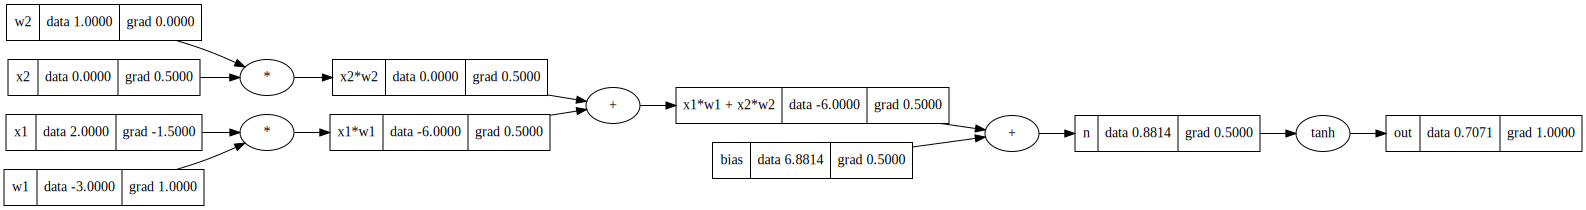

In [73]:
# and now we will be sequentially calling the _backward function to fill out these gradient values

# CAUTION: add base case, i.e., out.grad = 1.0 as we have initialised all the gradients with 0 values

out.grad = 1.0

# from here we will be moving backward and sequentially calling the _backward() method

out._backward()

n._backward()

x1w1x2w2._backward()

bias._backward()    # but nothing happens when we call this as `b` is a leaf node and it doesn't have a _backward()

x1w1._backward()
x2w2._backward()

draw_graph(out)

In [81]:
# now lets add one more method `backward()` in our Value class which does this backpropagation for us in order
# one thing that we need to know before doing this is to understand what is topological sort
# when we call topological sort on any node, it first visits all its children and once they are all visited, then and then only it visits the passed node

class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self,), _op='tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []

    visited = set()   # maintaining an empty set of visited node

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:   # call topological sort for all the children of v
          build_topo(child)

        topo.append(v)    # append the result of all this search in a result list

    build_topo(self)    # calling topological sort in the current node

    self.grad = 1.0   # initialize the base case for the called node

    for node in reversed(topo):
      node._backward()

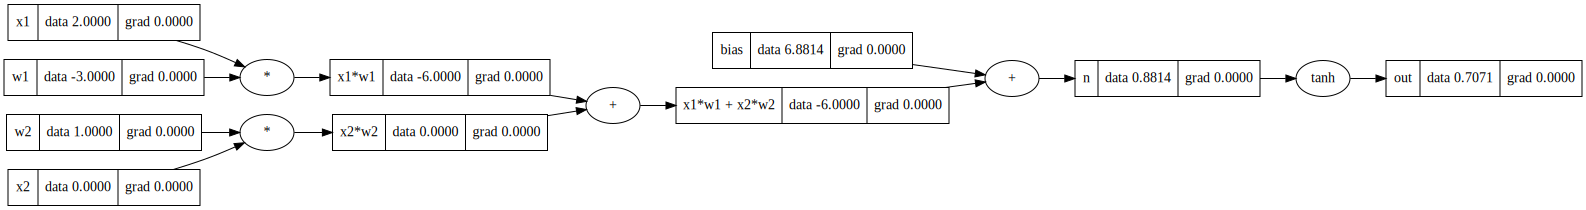

In [82]:
# now lets test this new backward method using the previous values

# inputs
x1 = Value(2.0, _label='x1')#
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias of the neuron
bias = Value(6.8813735870195432, _label='bias')

x1w1 = x1*w1
x2w2 = x2*w2

x1w1._label = 'x1*w1'
x2w2._label = 'x2*w2'

# x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias
n._label = 'n'

out = n.tanh()
out._label = 'out'

draw_graph(out)

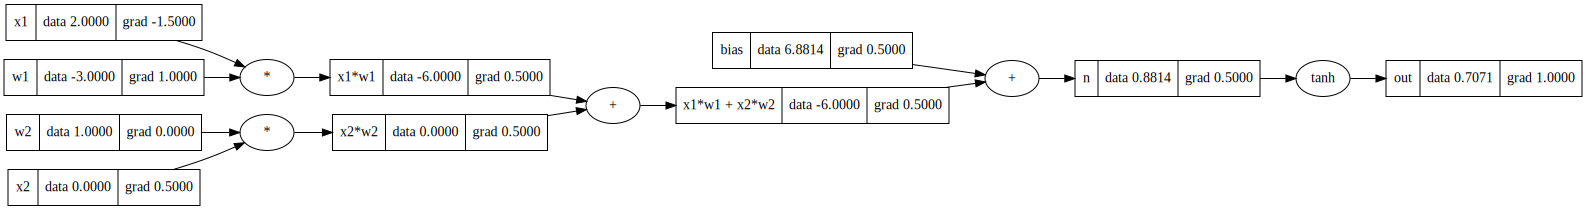

In [83]:
out.backward()
draw_graph(out)

# There's A BUG!!!

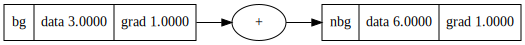

In [84]:
bg = Value(3.0, _label='bg')
nbg = bg + bg
nbg._label = 'nbg'
nbg.backward()

draw_graph(nbg)

In [78]:
# so if we have a variable which is participates in more than one `op` then when we call `_backward()` on it, we will arrive at that node two times
# and this will create a `Race Condition` in which whatever the `op` is called at last will rewrite its value and hence the previous value will be lost
# to fix this bug, we need to look into the multivatiable case of chain rule

<a href="https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case">Multivativariable Case of Chain Rule</a>

In [85]:
# so now we know that in such case we need to accumulate the derivative, so, let's change implementation of addition, multiplication and tanh methods
# to account for this case

class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad   # <-
      other.grad += 1.0 * out.grad   # <-

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad   # <-
      other.grad += self.data * out.grad   # <-

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self,), _op='tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad   # <-

    out._backward = _backward

    return out

  def backward(self):
    topo = []

    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)

        topo.append(v)

    build_topo(self)

    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

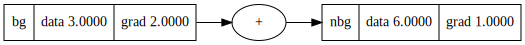

In [86]:
bg = Value(3.0, _label='bg')
nbg = bg + bg
nbg._label = 'nbg'
nbg.backward()

draw_graph(nbg)